# REPORT CONFIGURATION
This section should be populated with the following values:
* Query - The JIRA JQL query to identify the relevant scope
* Title - A description of the scope to include in the reports.
* Days to Extrapolate - For forecasting completion & creation rates, how much historically data should be considered.  Generally, data should be considered in 7-day blocks to avoid any weekend bias.
* Start Dates - The first date to include in reports.
* End Dates - The last date to include in reports.  This date can be future dated.  All dates beyond the current date will be based on extrapolation.

In [1]:
query = 'created >= -30d AND labels = Integration_Defects and issuekey != WEB-1892 '
title = "Log10 Integration Work"
days_to_extrapolate = 14
start_date="2024-07-30"
end_date="2024-08-12"

# Examples:

# query = 'issuekey in portfolioChildIssuesOf("FSP-8899")'
# title = "Dev Distractions Scope"
# days_to_extrapolate = 14
# start_date="2024-07-01"
# end_date="2024-10-01"

# query = 'issuekey in portfolioChildIssuesOf("PWD-337") or issuekey in portfolioChildIssuesOf("PWD-281")'
# title = "Pilotbase Milestone 1 Scope"
# days_to_extrapolate = 14
# start_date="2024-06-15"
# end_date="2024-09-01"


# SETUP CONNECTIONS AND CONFIGURATION

In [2]:
# Dependency install and import 
!pip -q install jira
!pip -q install tqdm
!pip -q install matplotlib
!pip -q install pandas

from jira import JIRA
import pandas as pd
import datetime
from datetime import *
from tqdm import tqdm
import time
import getpass
import matplotlib.pyplot as plt

In [3]:
# Jira Connection
needs_new_connection = False

if 'j' in globals():
    print("Do you want to reconnect to JIRA? ('Y' to reconnect)")
    reconnect = input()

    if reconnect.strip().upper() in ("1","Y","YES"):
        needs_new_connection = True
else:
    needs_new_connection = True
        
if needs_new_connection:
    print("JIRA Username:")
    time.sleep(.25)
    un = input()
    print(" ")
    print("JIRA API Key (generated at https://id.atlassian.com/manage-profile/security/api-tokens):")
    time.sleep(.25)
    pw = getpass.getpass()
    
    j = JIRA("https://flightschedulepro.atlassian.net/", basic_auth=(un, pw))
    pw = ''

JIRA Username:


 joseph.king@flightschedulepro.com


 
JIRA API Key (generated at https://id.atlassian.com/manage-profile/security/api-tokens):


 ········


In [4]:
# REFERENCE VALUES

# Status Categories
DONE_STATUSES = ['Done']
IN_VALIDATION_STATUSES = ['QA Ready','In QA','Merged']
IN_DEV_STATUSES = ['In Progress',  'Code Review', 'Development', 'In Development']
ENG_BACKLOG_STATUSES = ['Selected for Development', 'Ready for Dev','Ready']
PM_BACKLOG_STATUSES = ['Backlog', 'Ready for Refinement']

# Issue Type Categories
PLANNING_ISSUE_TYPES = ['Theme','Initiative']
EPIC_ISSUE_TYPES = ['Epic']
STANDARD_ISSUE_TYPES = ['Bug','DevOps Task','Release','Story','Support','Task','Test']
SUB_TASK_ISSUE_TYPES = ['Defect','DevOps Sub-task','Integration Tests','Product Acceptance Change','Sub-task']

# Fetch all fields and make a map of custom fields
allfields = j.fields()
fieldMap = {field['name']:field['id'] for field in allfields}

# SUPPORT FUNCTIONS

In [5]:
# def fetch_jira_issues_to_dataframe() # GET ALL TICKETS FOR A QUERY AND RETURN A DATAFRAME
def fetch_jira_issues_to_dataframe(jira_conn, jql_query):
    """
    Fetch issues from Jira based on a JQL query and return a DataFrame with specific fields.

    Parameters:
    jira_conn (JIRA): An authenticated JIRA connection object.
    jql_query (str): The JQL query to fetch issues.

    Returns:
    pd.DataFrame: A DataFrame containing issue key, status, resolution, created date, resolution date, issue type,
                  parent story, parent epic, and parent initiative.
    """
    issues = jira_conn.search_issues(jql_query, maxResults=False, expand='changelog', fields="key,summary,status,resolution,created,resolutiondate,issuetype,parent,customfield_10008,customfield_10009,fixVersions")


    data = []
    for issue in tqdm(issues, desc="Processing issues"):
        
        issue_key = issue.key
        issue_summary = issue.fields.summary
        resolution = issue.fields.resolution.name if issue.fields.resolution else None
       
        # Issue Type values
        issue_type = issue.fields.issuetype.name
        issue_type_category = None
        
        if issue_type in PLANNING_ISSUE_TYPES:
            issue_type_category = 'PLANNING'
        elif issue_type in EPIC_ISSUE_TYPES:
            issue_type_category = 'EPIC'
        elif issue_type in STANDARD_ISSUE_TYPES:
            issue_type_category = 'STANDARD'
        elif issue_type in SUB_TASK_ISSUE_TYPES:
            issue_type_category = 'SUBTASK'
        else:
            print(f"Unable to make issue type {issue_type} to issue_type_category")
        
        # Status values
        status = issue.fields.status.name
        status_category = None
        if status in DONE_STATUSES:
            status_category = 'Done'
        elif status in IN_VALIDATION_STATUSES:
            status_category = 'Validation'
        elif status in IN_DEV_STATUSES:
            status_category = 'Development'
        elif status in ENG_BACKLOG_STATUSES:
            status_category = 'Eng Backlog'
        elif status in PM_BACKLOG_STATUSES:
            status_category = 'PM Backlog'
        else:
            print(f"Unable to map status {status} to status_category")

        # Print the fix versions (release versions) associated with the issue
        release_date = None
        if hasattr(issue.fields, 'fixVersions'):
            for version in issue.fields.fixVersions:
                if hasattr(version, 'releaseDate'):
                    release_date_temp = pd.to_datetime(version.releaseDate).tz_localize(None)

                    if release_date is None or release_date_temp < release_date:
                        release_date = release_date_temp
                        
        # Dates 
        created_date_raw = issue.fields.created
        resolution_date_raw = issue.fields.resolutiondate if issue.fields.resolutiondate else None
        
        #print(f"{issue_key} - {created_date_raw} - {resolution_date_raw}")
        created_date = pd.to_datetime(created_date_raw).tz_localize(None)
        resolution_date = pd.to_datetime(resolution_date_raw).tz_localize(None) if resolution_date_raw else None

        # Pull historical status change dates.
        changelog = issue.changelog
        # Loop through the changelog to find when the status changed to "In Progress"
        pm_backlog_date = None
        eng_backlog_date = None
        dev_date = None
        validation_date = None
        done_date = None
        
        for history in changelog.histories:
            changed_date = history.created
            
            for item in history.items:
                changed_field = item.field
                new_value = item.toString

                if changed_field == "status":
                    if new_value in DONE_STATUSES:
                        if not done_date or changed_date > done_date:
                            done_date = changed_date
                    elif new_value in IN_VALIDATION_STATUSES:
                        if not validation_date or changed_date > validation_date:
                            validation_date = changed_date
                    elif new_value in IN_DEV_STATUSES:
                        if not dev_date or changed_date > dev_date:
                            dev_date = changed_date
                    elif new_value in ENG_BACKLOG_STATUSES:
                        if not eng_backlog_date or changed_date > eng_backlog_date:
                            eng_backlog_date = changed_date


        # If the ticket is moved backwards, status dates can get weird.  Clean that up by removing dates from future stages
        if status in IN_VALIDATION_STATUSES:
            done_date = None
        elif status in IN_DEV_STATUSES:
            done_date = None
            validation_date = None
        elif status in ENG_BACKLOG_STATUSES:
            done_date = None
            validation_date = None
            dev_date = None
        elif status in PM_BACKLOG_STATUSES:
            done_date = None
            validation_date = None
            dev_date = None
            eng_backlog_date = None

        # Normalize dates
        done_date = pd.to_datetime(done_date).tz_localize(None) if done_date else None
        validation_date = pd.to_datetime(validation_date).tz_localize(None) if validation_date else None
        dev_date = pd.to_datetime(dev_date).tz_localize(None) if dev_date else None
        eng_backlog_date = pd.to_datetime(eng_backlog_date).tz_localize(None) if eng_backlog_date else None
        pm_backlog_date = created_date # default the PM backlog date to created

        # Map hierarchical values
        parent_story = None
        parent_epic = None
        parent_initiative = None
        parent_theme = None

        parent = issue.fields.parent.key if hasattr(issue.fields, 'parent') else None

        if issue_type in PLANNING_ISSUE_TYPES:
            issue_type_category = 'PLANNING'
        elif issue_type in EPIC_ISSUE_TYPES:
            issue_type_category = 'EPIC'
        elif issue_type in STANDARD_ISSUE_TYPES:
            issue_type_category = 'STANDARD'
        elif issue_type in SUB_TASK_ISSUE_TYPES:
            issue_type_category = 'SUBTASK'
        else:
            print(f"Unable to make issue type {issue_type} to issue_type_category")
        
        match issue_type_category:
            case "PLANNING":
                parent_theme = parent
            case "EPIC":
                parent_initiative = parent
            case "SUBTASK":
                # subtasks.  Parent = Story
                parent_story = parent
            case "STANDARD":
                # standard issue type
                parent_epic = parent
            case _:
                print(f"Unable to map heirarchy values for issue {issue_key}")
                
 
        data.append({
            'Issue Key': issue_key,
            'Summary': issue_summary,
            'Status': status,
            'Status Category': status_category,
            'Resolution': resolution,
            'Created Date': created_date,
            'PM Backlog Date': pm_backlog_date,
            'Eng Backlog Date': eng_backlog_date,
            'Development Date': dev_date,
            'Validation Date': validation_date,
            'Done Date': done_date,
            'Release Date': release_date,
            'Resolution Date': resolution_date,
            'Issue Type': issue_type,
            'Issue Type Category': issue_type_category,
            'Parent Story': parent_story,
            'Parent Story Name': None,
            'Parent Epic': parent_epic,
            'Parent Epic Name': None,
            'Parent Initiative': parent_initiative,
            'Parent Initiative Name': None,
            'Parent Theme': parent_theme
        })

    df = pd.DataFrame(data)

    # Second pass to populate the parent epic and parent initiative fields
    for i, row in df.iterrows():
        if row['Parent Initiative']:
            parent_initiative_row = df[df['Issue Key'] == row['Parent Initiative']]
            if not parent_initiative_row.empty:
                df.at[i, 'Parent Initiative Name'] = parent_initiative_row['Summary'].values[0]
                df.at[i, 'Parent Theme'] = parent_initiative_row['Parent Theme'].values[0]
                
    for i, row in df.iterrows():
        if row['Parent Epic']:
            parent_epic_row = df[df['Issue Key'] == row['Parent Epic']]
            if not parent_epic_row.empty:
                df.at[i, 'Parent Epic Name'] = parent_epic_row['Summary'].values[0]
                df.at[i, 'Parent Initiative'] = parent_epic_row['Parent Initiative'].values[0]
                df.at[i, 'Parent Initiative Name'] = parent_epic_row['Parent Initiative Name'].values[0]
                df.at[i, 'Parent Theme'] = parent_epic_row['Parent Theme'].values[0]

    for i, row in df.iterrows():
        if row['Parent Story']:
            parent_story_row = df[df['Issue Key'] == row['Parent Story']]
            if not parent_story_row.empty:
                df.at[i, 'Parent Story Name'] = parent_story_row['Summary'].values[0]
                df.at[i, 'Parent Epic'] = parent_story_row['Parent Epic'].values[0]
                df.at[i, 'Parent Epic Name'] = parent_story_row['Parent Epic Name'].values[0]
                df.at[i, 'Parent Initiative'] = parent_story_row['Parent Initiative'].values[0]
                df.at[i, 'Parent Initiative Name'] = parent_story_row['Parent Initiative Name'].values[0]
                df.at[i, 'Parent Theme'] = parent_story_row['Parent Theme'].values[0]

    return df

In [6]:
# def generate_burndown_chart() # GENERATE A BURNDOWN CHART WITH TOTAL SCOPE, RESOLVED SCOPE, REMAINING SCOPE
def generate_burndown_chart(df, start_date=None, end_date=None, extrapolate_days=None, title=None):
    """
    Generate a burndown chart from a DataFrame containing Jira issue data.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'Created Date', 'Resolution Date', and 'Status'.

    Returns:
    None: Displays the burndown chart.
    """

    # Set the start and end date for the burndown chart
    if start_date is None:
        start_date = df['Created Date'].min()
    else: 
        start_date = pd.to_datetime(start_date).tz_localize(None)

    if end_date is None:
        end_date = df['Resolution Date'].max()
    else: 
        end_date = pd.to_datetime(end_date).tz_localize(None)
  
    # Ensure both start_date and end_date are timezone-naive (or have the same timezone)
    if start_date.tzinfo is not None:
        start_date = start_date.tz_convert(None)
    if end_date.tzinfo is not None:
        end_date = end_date.tz_convert(None)
        
    now = pd.Timestamp('now').normalize()
    
    if title is None:
        title = 'Burndown Chart'
        
    # Create a date range
    date_range = pd.date_range(start=start_date, end=end_date)

    # Initialize a DataFrame to hold the burndown data
    burndown_data = pd.DataFrame(date_range, columns=['Date'])
    burndown_data['Total Tasks'] = 0
    burndown_data['Remaining Tasks'] = 0
    burndown_data['Resolved Tasks'] = 0

    # Initialize extrapolation values
    daily_resolution_rate = None
    daily_creation_rate = None

    # Calculate the number of tasks remaining on each date
    for i, row in burndown_data.iterrows():
        date = row['Date']
        
        if date <= now:
            # prior to today we have actuals
            total_tasks = df[(df['Created Date'] <= date)].shape[0]
            resolved_tasks = df[(df['Resolution Date'] <= date)].shape[0]
            remaining_tasks = total_tasks - resolved_tasks
            
            burndown_data.at[i, 'Total Tasks'] = total_tasks
            burndown_data.at[i, 'Remaining Tasks'] = remaining_tasks
            burndown_data.at[i, 'Resolved Tasks'] = resolved_tasks
        else:
            # Extrapolate future data if extrapolate_days is provided
            burndown_data.at[i, 'Total Tasks'] = None
            burndown_data.at[i, 'Remaining Tasks'] = None
            burndown_data.at[i, 'Resolved Tasks'] = None
            
            if extrapolate_days is not None:
                # Calculate the trajectories the first time
                if daily_resolution_rate is None or daily_creation_rate is None:           
                    # Calculate the trajectory based on the last "X" days
                    trajectory_period = min(extrapolate_days, len(date_range))
                    recent_data = burndown_data[(burndown_data['Date'] <= now)].tail(trajectory_period)
                    
                    daily_resolution_rate = recent_data['Resolved Tasks'].diff().mean()
                    daily_creation_rate = recent_data['Total Tasks'].diff().mean()
                    print(f"Extrapolated outcomes based on {trajectory_period} days")
                    print(f"-- Daily Resolution Rate: {round(daily_resolution_rate,2)}")
                    print(f"-- Daily Creation Rate: {round(daily_creation_rate,2)}")
                    
                    burndown_data.at[i-1, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks']
                    burndown_data.at[i-1, 'Remaining Tasks (F)'] = burndown_data.at[i-1, 'Remaining Tasks']
                    burndown_data.at[i-1, 'Resolved Tasks (F)'] = burndown_data.at[i-1, 'Resolved Tasks']

                        
                burndown_data.at[i, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks (F)'] + daily_creation_rate
                burndown_data.at[i, 'Remaining Tasks (F)'] = burndown_data.at[i-1, 'Remaining Tasks (F)'] + daily_creation_rate - daily_resolution_rate
                burndown_data.at[i, 'Resolved Tasks (F)'] = burndown_data.at[i-1, 'Resolved Tasks (F)'] + daily_resolution_rate


    # Plot the burndown chart
    plt.figure(figsize=(10, 4))
    plt.plot(burndown_data['Date'], burndown_data['Total Tasks'], color='red', linestyle='-', label='Total Tasks')
    plt.plot(burndown_data['Date'], burndown_data['Remaining Tasks'], color='orange', linestyle='-', label='Remaining Tasks')
    plt.plot(burndown_data['Date'], burndown_data['Resolved Tasks'], color='green', linestyle='-', label='Resolved Tasks')

    if extrapolate_days is not None:
        plt.plot(burndown_data['Date'], burndown_data['Total Tasks (F)'], color='red', linestyle='dashed')
        plt.plot(burndown_data['Date'], burndown_data['Remaining Tasks (F)'], color='orange', linestyle='dashed')
        plt.plot(burndown_data['Date'], burndown_data['Resolved Tasks (F)'], color='green', linestyle='dashed')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Tickets')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
# def def generate_stacked_bar_chart() # GENERATE A CHART WITH TOTAL SCOPE BROKEN DOWN BY STATUS
def generate_stacked_bar_chart(df, start_date=None, end_date=None, extrapolate_days=None, title=None):
    """
    Generate a stacked bar chart based on statuses over time.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'Created Date', 'Resolution Date', and 'Status'.

    Returns:
    None: Displays the burndown chart.
    """

    # Set the start and end date for the burndown chart
    if start_date is None:
        start_date = df['Created Date'].min()
    else: 
        start_date = pd.to_datetime(start_date).tz_localize(None)

    if end_date is None:
        end_date = df['Resolution Date'].max()
    else: 
        end_date = pd.to_datetime(end_date).tz_localize(None)
  
    # Ensure both start_date and end_date are timezone-naive (or have the same timezone)
    if start_date.tzinfo is not None:
        start_date = start_date.tz_convert(None)
    if end_date.tzinfo is not None:
        end_date = end_date.tz_convert(None)
        
    now = pd.Timestamp('now').normalize() + pd.Timedelta(days=1)
    
    if title is None:
        title = 'Stacked Bar Status Chart'
        
    # Create a date range
    date_range = pd.date_range(start=start_date, end=end_date)

    # Initialize a DataFrame to hold the burndown data
    burndown_data = pd.DataFrame(date_range, columns=['Date'])
    burndown_data['Total Tasks'] = 0
    burndown_data['PM Backlog Tasks'] = 0
    burndown_data['Eng Backlog Tasks'] = 0
    burndown_data['In Development Tasks'] = 0
    burndown_data['In Validation Tasks'] = 0
    burndown_data['Done Tasks'] = 0

    # Initialize extrapolation values
    daily_resolution_rate = None
    daily_creation_rate = None

    # Calculate the number of tasks remaining on each date
    for i, row in burndown_data.iterrows():
        date = row['Date']
        
        if date <= now:
            # prior to today we have actuals
            total_tasks = df[(df['Created Date'] <= date)].shape[0]
            done_tasks = df[(df['Done Date'] <= date)].shape[0] 
            in_validation_tasks = df[(df['Validation Date'] <= date) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            in_development_tasks = df[(df['Development Date'] <= date) & ((df['Validation Date'].isna()) | (df['Validation Date'] > date)) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            eng_backlog_tasks = df[(df['Eng Backlog Date'] <= date) & ((df['Development Date'].isna()) | (df['Development Date'] > date)) & ((df['Validation Date'].isna()) | (df['Validation Date'] > date)) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            pm_backlog_tasks = df[(df['PM Backlog Date'] <= date) & ((df['Eng Backlog Date'].isna()) | (df['Eng Backlog Date'] > date)) & ((df['Development Date'].isna()) | (df['Development Date'] > date)) & ((df['Validation Date'].isna()) | (df['Validation Date'] > date)) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            #pm_backlog_tasks = total_tasks - done_tasks - in_validation_tasks - in_development_tasks - eng_backlog_tasks
            
            burndown_data.at[i, 'Total Tasks'] = total_tasks
            burndown_data.at[i, 'PM Backlog Tasks'] = pm_backlog_tasks
            burndown_data.at[i, 'Eng Backlog Tasks'] = eng_backlog_tasks
            burndown_data.at[i, 'In Development Tasks'] = in_development_tasks
            burndown_data.at[i, 'In Validation Tasks'] = in_validation_tasks
            burndown_data.at[i, 'Done Tasks'] = done_tasks
        else:
            # Extrapolate future data if extrapolate_days is provided
            burndown_data.at[i, 'Total Tasks'] = None
            burndown_data.at[i, 'PM Backlog Tasks'] = None
            burndown_data.at[i, 'Eng Backlog Tasks'] = None
            burndown_data.at[i, 'In Development Tasks'] = None
            burndown_data.at[i, 'In Validation Tasks'] = None
            burndown_data.at[i, 'Done Tasks'] = None
            
            if extrapolate_days is not None:
                # Calculate the trajectories the first time
                if daily_resolution_rate is None or daily_creation_rate is None:           
                    # Calculate the trajectory based on the last "X" days
                    trajectory_period = min(extrapolate_days, len(date_range))
                    recent_data = burndown_data[(burndown_data['Date'] <= now)].tail(trajectory_period)
                    
                    daily_resolution_rate = recent_data['Done Tasks'].diff().mean()
                    daily_creation_rate = recent_data['Total Tasks'].diff().mean()
                    print(f"Extrapolated outcomes based on {trajectory_period} days")
                    print(f"-- Daily Resolution Rate: {round(daily_resolution_rate,2)}")
                    print(f"-- Daily Creation Rate: {round(daily_creation_rate,2)}")
                    
                    burndown_data.at[i-1, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks']
                    burndown_data.at[i-1, 'Done Tasks (F)'] = burndown_data.at[i-1, 'Done Tasks']
                    burndown_data.at[i-1, 'Remaining Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks (F)'] - burndown_data.at[i-1, 'Done Tasks (F)']
            
                burndown_data.at[i, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks (F)'] + daily_creation_rate
                burndown_data.at[i, 'Done Tasks (F)'] = burndown_data.at[i-1, 'Done Tasks (F)'] + daily_resolution_rate
                if burndown_data.at[i, 'Done Tasks (F)'] < 0:
                    burndown_data.at[i, 'Done Tasks (F)'] = 0
                burndown_data.at[i, 'Remaining Tasks (F)'] = burndown_data.at[i, 'Total Tasks (F)'] - burndown_data.at[i, 'Done Tasks (F)']


    # Plot the burndown chart
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(burndown_data['Date'], burndown_data['Total Tasks'], color='black', linestyle='-', label='Total')

    # Plot the stacked bars
    ax.bar(burndown_data['Date'], burndown_data['PM Backlog Tasks'], label='PM Backlog', color='red')
    ax.bar(burndown_data['Date'], burndown_data['Eng Backlog Tasks'], bottom=burndown_data['PM Backlog Tasks'], label='Eng Backlog', color='orange')
    ax.bar(burndown_data['Date'], burndown_data['In Development Tasks'], bottom=burndown_data['PM Backlog Tasks']+burndown_data['Eng Backlog Tasks'], label='In Development', color='yellow')
    ax.bar(burndown_data['Date'], burndown_data['In Validation Tasks'], bottom=burndown_data['PM Backlog Tasks']+burndown_data['Eng Backlog Tasks']+burndown_data['In Development Tasks'], label='In Validation', color='green')
    ax.bar(burndown_data['Date'], burndown_data['Done Tasks'], bottom=burndown_data['PM Backlog Tasks']+burndown_data['Eng Backlog Tasks']+burndown_data['In Development Tasks']+burndown_data['In Validation Tasks'], label='Done', color='blue')

    if extrapolate_days is not None:
        plt.plot(burndown_data['Date'], burndown_data['Total Tasks (F)'], color='black', linestyle='dashed')
        ax.bar(burndown_data['Date'], burndown_data['Done Tasks (F)'], bottom=burndown_data['Remaining Tasks (F)'], color='blue', alpha=0.4)
        #plt.plot(burndown_data['Date'], burndown_data['Done Tasks (F)'], color='blue', linestyle='dashed')
        
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Tickets')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
# def generate_bar_chart() # GENERATE A BAR CHART BASED ON VOLUME FOR AN IDENTIFIED COLUMN
def generate_bar_chart(df, column, title=None):
    """
    GENERATE A BAR CHART BASED ON VOLUME FOR AN IDENTIFIED COLUMN

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'Created Date', 'Resolution Date', and 'Status'.
    column (string): Name of the column for the buckets used on the horizontal axis.

    Returns:
    None: Displays the chart.
    """
    
    if title is None:
        title = 'Bar Chart'
    
    bin_counts = df[column].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Number')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [9]:
# def generate_whisker_chart() # GENERATE A WHISKER CHART BASED ON VOLUME FOR AN IDENTIFIED COLUMN
def generate_whisker_chart(df, columns, ylabel=None, title=None):
    """
    GENERATE A WHISKER CHART BASED ON SELECTED COLUMNS

    Parameters:
    df (pd.DataFrame): DataFrame 
    columns (string[]): Name of the columns for analysis.

    Returns:
    None: Displays the chart.
    """
    
    if title is None:
        title = 'Bar Chart'
        
    # Create the box plot
    # Define colors for the box plots
    colors = {
        'boxes': 'DarkOrange',
        'whiskers': 'DarkOrange',
        'medians': 'Blue',
        'caps': 'Green'
    }

    plt.figure(figsize=(8, 6))
    boxplot = df[columns].boxplot(
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='DarkOrange'),
        capprops=dict(color=colors['caps']),
        whiskerprops=dict(color=colors['whiskers']),
        flierprops=dict(markerfacecolor='red', marker='o', markersize=5, linestyle='none'),
        medianprops=dict(color=colors['medians']),
        vert=True
    )
    
    plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
        
    plt.xticks(rotation=45)

# COLLECT AND ANALYZE DATA FOR REPORTS

In [13]:
# RETRIEVE DATA
query = "(" + query + ") and (resolution is empty or resolution = Done)"
df = fetch_jira_issues_to_dataframe(j, query)

Processing issues: 100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 668.79it/s]


In [18]:
# Cycle time calculations
# Defintions:
# Lead Time: Created until Done
    # Cycle Time: Development Start until Done
        # Development Time: Development Start until QA Review
        # Validation Time: QA Start Until Done
# + Release: Base Metric + Time from Done to Release (FUTURE)

# only do calcs on done tickets
df_ct_calcs = df[df['Done Date'].notna()].copy()
df_ct_calcs["Lead Time (days)"] = round((df_ct_calcs['Done Date'] - df_ct_calcs['Created Date']).dt.total_seconds() / (24 * 60 * 60),2)
df_ct_calcs["Cycle Time (days)"] = round((df_ct_calcs['Done Date'] - df_ct_calcs['Development Date']).dt.total_seconds() / (24 * 60 * 60),2)
df_ct_calcs["CT Development Time (days)"] = round((df_ct_calcs['Validation Date'] - df_ct_calcs['Development Date']).dt.total_seconds() / (24 * 60 * 60),2)
df_ct_calcs["CT Validation Time (days)"] = round((df_ct_calcs['Done Date'] - df_ct_calcs['Validation Date']).dt.total_seconds() / (24 * 60 * 60),2)

# Calculate 'Release Time (days)' only when 'Release Date' is not None
df_ct_calcs["Release Time (days)"] = df_ct_calcs.apply(
    lambda row: round((row['Release Date'] - row['Done Date']).total_seconds() / (24 * 60 * 60), 2) if row['Release Date'] is not None else None,
    axis=1
)
# merge calced data into primary df
# Drop the column if it exists
df = df.drop(columns=["Lead Time (days)","Cycle Time (days)","CT Development Time (days)","CT Validation Time (days)","Release Time (days)"], errors='ignore')
df = df.merge(df_ct_calcs[['Issue Key',"Lead Time (days)","Cycle Time (days)","CT Development Time (days)","CT Validation Time (days)","Release Time (days)"]],on="Issue Key",how="left")

In [19]:
# Create subsets for future reports
df_filtered_standard_issues = df[df['Issue Type Category'] == "STANDARD"]
df_filtered_sub_tasks_issues = df[df['Issue Type Category'] == "SUBTASK"]

In [20]:
# Analyze Defects / other subtasks
defects = df_filtered_sub_tasks_issues[df_filtered_sub_tasks_issues['Issue Type'] == "Defect"].groupby(['Parent Story']).agg({'Issue Key': 'count'}).rename(columns={'Issue Key': 'Defect Count'})
sub_tasks_analysis = df_filtered_sub_tasks_issues.groupby(['Parent Story']).agg({'Issue Key': 'count'}).rename(columns={'Issue Key': 'All Subtasks Count'})
sub_tasks_analysis = sub_tasks_analysis.merge(defects, on="Parent Story", how="left").fillna(0)
sub_tasks_analysis['Defect Percentage'] = (sub_tasks_analysis['Defect Count'] / sub_tasks_analysis['All Subtasks Count']) * 100

# Bucket the percentages
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
sub_tasks_analysis['Defect Percentage Bin'] = pd.cut(sub_tasks_analysis['Defect Percentage'], bins=bins, labels=labels, include_lowest=True)


# BURNDOWN STACKED BAR

Extrapolated outcomes based on 14 days
-- Daily Resolution Rate: 0.12
-- Daily Creation Rate: 0.5


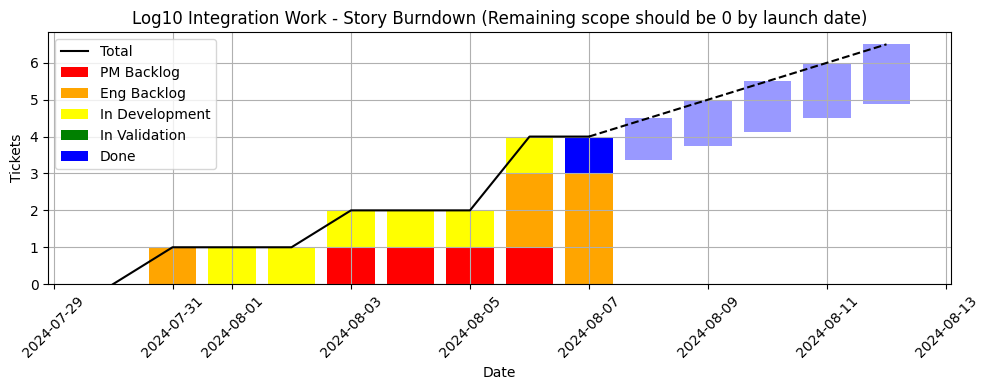

Extrapolated outcomes based on 14 days
-- Daily Resolution Rate: 0.25
-- Daily Creation Rate: 1.12


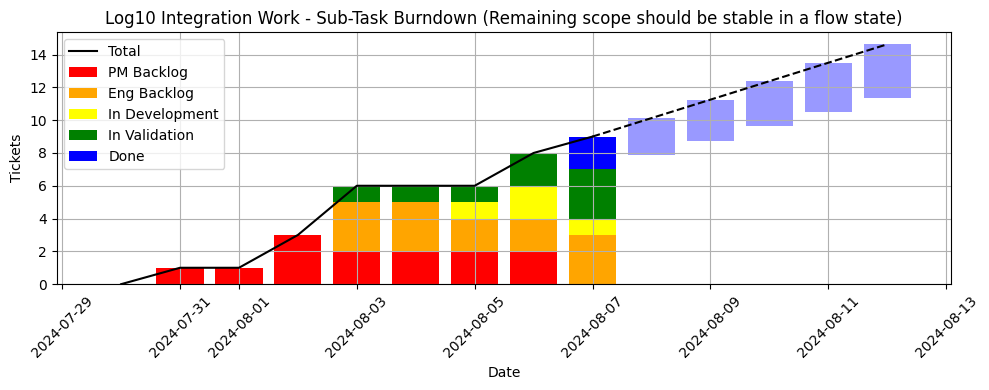

Extrapolated outcomes based on 14 days
-- Daily Resolution Rate: 0.38
-- Daily Creation Rate: 1.62


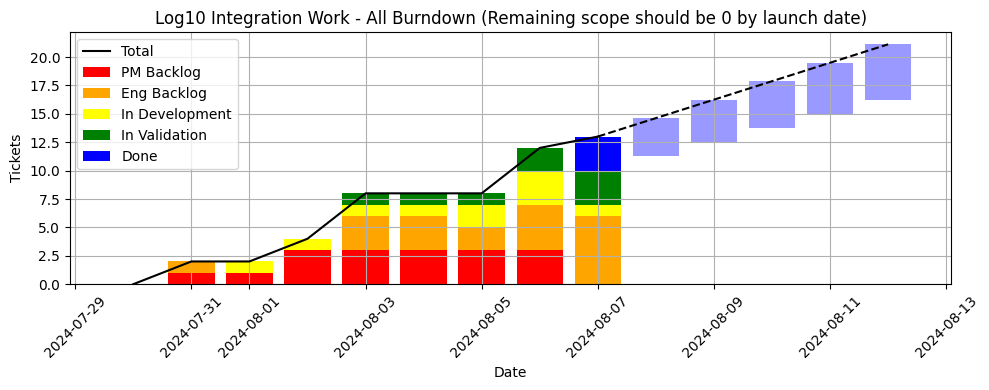

In [21]:
generate_stacked_bar_chart(df_filtered_standard_issues, start_date=start_date, end_date=end_date, extrapolate_days=days_to_extrapolate, title=title + ' - Story Burndown (Remaining scope should be 0 by launch date)')
generate_stacked_bar_chart(df_filtered_sub_tasks_issues, start_date=start_date, end_date=end_date, extrapolate_days=days_to_extrapolate, title=title + ' - Sub-Task Burndown (Remaining scope should be stable in a flow state)')
generate_stacked_bar_chart(df, start_date=start_date, end_date=end_date, extrapolate_days=days_to_extrapolate, title=title + ' - All Burndown (Remaining scope should be 0 by launch date)')

# DEFECTS PER STORY

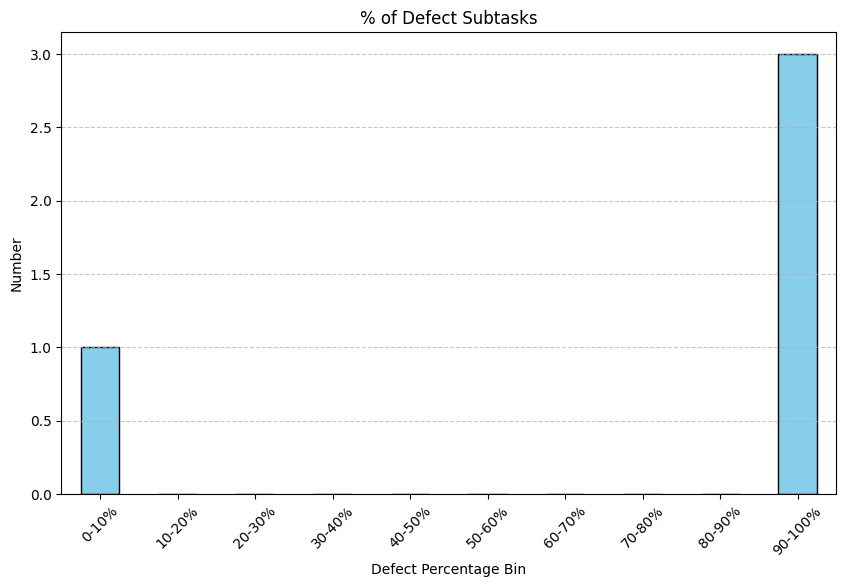

In [22]:
generate_bar_chart(sub_tasks_analysis,'Defect Percentage Bin',"% of Defect Subtasks")

# CYCLE TIME

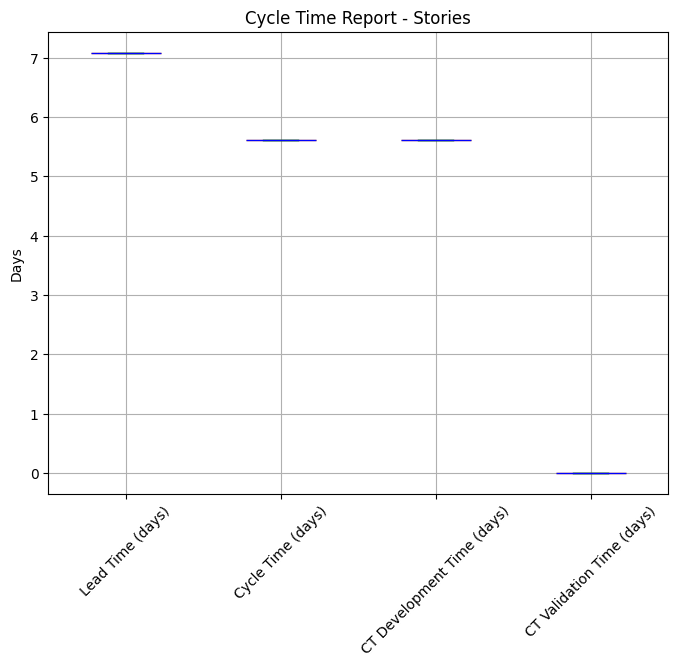

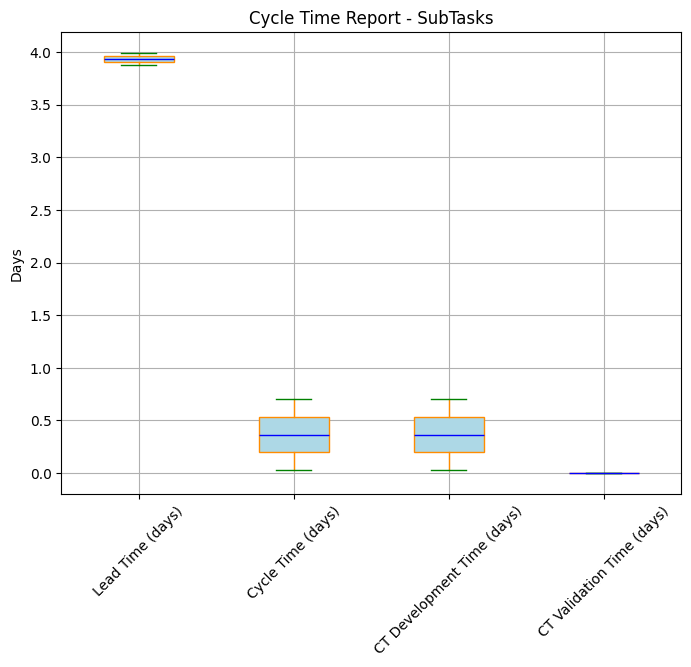

In [23]:
generate_whisker_chart(df_filtered_standard_issues, 
                       columns=['Lead Time (days)', 'Cycle Time (days)', 'CT Development Time (days)', 'CT Validation Time (days)', 'Release Time (days)'], 
                       ylabel="Days", title="Cycle Time Report - Stories")
generate_whisker_chart(df_filtered_sub_tasks_issues, 
                       columns=['Lead Time (days)', 'Cycle Time (days)', 'CT Development Time (days)', 'CT Validation Time (days)', 'Release Time (days)'], 
                       ylabel="Days", title="Cycle Time Report - SubTasks")